## Options structural break detection, 3yrs

In [1]:
import os 
import numpy as np
import pandas as pd
from datetime import datetime
from pprint import pprint

In [2]:
import warnings
warnings.filterwarnings(action='once')
warnings.simplefilter('once', category=UserWarning)

In [3]:
from time_series_utils import timeseries_evaluation_metrics_func, mean_absolute_percentage_error,\
                          find_best_ARIMA_model, get_nth_train_split

Importing plotly failed. Interactive plots will not work.


## Cboe Options Historical Volume and Put/Call Ratios

### Index Options

In [4]:
from datetime import datetime, timedelta
import pickle

In [5]:
with open('EQT_options.pkl', 'rb') as f:
    df2 = pickle.load(f)

In [6]:
df2 = df2[:'2013-01-01']


<AxesSubplot:xlabel='Date'>

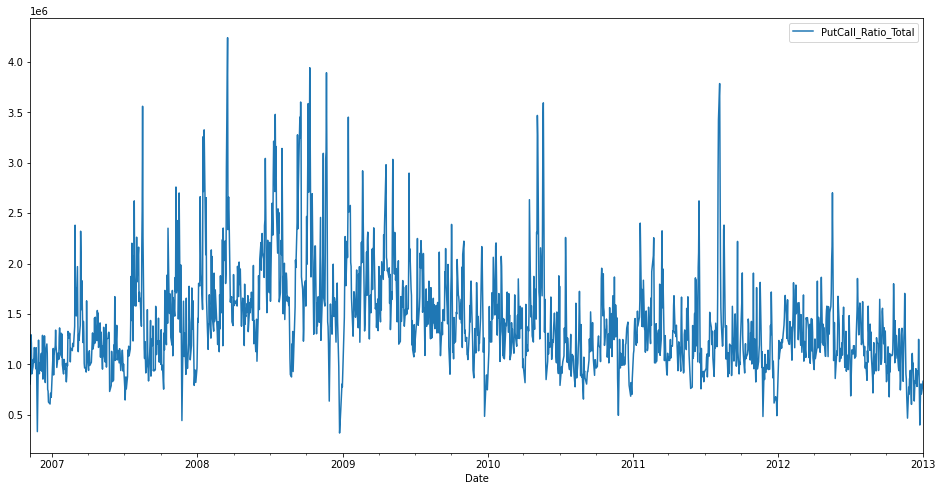

In [7]:
df2.plot(figsize=(16,8))

## What we are going to do. 

start_time + 6 months = interval_1 <- hyperparameter tuning 

then fit and predict the next 1 week. 

new start_time is interval_1 end + 1 weeks => 
start_time_1 + 6 months =  interval_2 <- hyperparameter tuning 

then fix and predict the next 1 week.

Repeat for 156 times. 

Repeat until 12 times.  

that's what we do. then also add new model pytorch_forecasting.

### Fine tune hyperparameter and forecast on moving window of 1 week increment up to 156 weeks (3 years) 

In [8]:
# Value Columns to be used in all models tuning
value_col = 'PutCall_Ratio_Total'

## Holt Winters Exponential Smoothing (ETS)

Find best hyperparameters using train2 and validation data. 

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## ARIMA and SARIMAX Model

In [10]:
## create an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

In [11]:
# force update on hyperparameters
best_params = None 

In [12]:
%%capture

ARIMA_MAPES = []
steps = 156  # number of windowing steps (unit week)

for i in range(steps):
    train_data, val_data, test_data = get_nth_train_split(df2, i, train_week_len=14)
    _, _, best_pdq_MAE = find_best_ARIMA_model(
        train_data, val_data, value_col=value_col)
    model_ARIMA = ARIMA(train_data[value_col], order=best_pdq_MAE).fit()
    test_pred_ARIMA = model_ARIMA.predict(start=test_data.index[0], end=test_data.index[-1])
    MAPE = mean_absolute_percentage_error(test_data[value_col], test_pred_ARIMA)
    ARIMA_MAPES.append((MAPE, (test_data.index[0], test_data.index[-1])))
    print("*********************************************")
    print()
    print(f"finishing step: {i}")
    print()
    print("**********************************************")
     
print(f"Arima MAPES:\n {ARIMA_MAPES}")

In [13]:
import pickle

with open('arima_interval_14w_EQT_2007-2009.pkl', 'wb') as f:
    pickle.dump(ARIMA_MAPES, f)

## Prophet

In [14]:
from prophet import Prophet

In [15]:
# force hyperparameters search
best_params = None 

In [16]:
ARIMA_MAPES

[(12.895988340185136,
  (Timestamp('2007-02-20 00:00:00', freq='D'),
   Timestamp('2007-02-26 00:00:00', freq='D'))),
 (27.608425492590214,
  (Timestamp('2007-02-27 00:00:00', freq='D'),
   Timestamp('2007-03-05 00:00:00', freq='D'))),
 (63.24011306008532,
  (Timestamp('2007-03-06 00:00:00', freq='D'),
   Timestamp('2007-03-12 00:00:00', freq='D'))),
 (16.205710285408127,
  (Timestamp('2007-03-13 00:00:00', freq='D'),
   Timestamp('2007-03-19 00:00:00', freq='D'))),
 (52.02262675174597,
  (Timestamp('2007-03-20 00:00:00', freq='D'),
   Timestamp('2007-03-26 00:00:00', freq='D'))),
 (16.736563266284506,
  (Timestamp('2007-03-27 00:00:00', freq='D'),
   Timestamp('2007-04-02 00:00:00', freq='D'))),
 (27.226104612589243,
  (Timestamp('2007-04-03 00:00:00', freq='D'),
   Timestamp('2007-04-09 00:00:00', freq='D'))),
 (9.36129136195075,
  (Timestamp('2007-04-10 00:00:00', freq='D'),
   Timestamp('2007-04-16 00:00:00', freq='D'))),
 (11.185780849349095,
  (Timestamp('2007-04-17 00:00:00', fr

In [17]:
arima_mapes_values = map(lambda x: x[0], ARIMA_MAPES) 
arima_mapes_df = pd.DataFrame(arima_mapes_values, columns=['mape'])
arima_mapes_df.head(3)

mape
0  12.895988
1  27.608425
2  63.240113

In [18]:
arima_mapes_norm = arima_mapes_df/arima_mapes_df.mean()
arima_mapes_norm.head(3)

mape
0  0.436356
1  0.934175
2  2.139829

In [19]:
arima_mapes_df.mean()

mape    29.553811
dtype: float64